In [1]:
%matplotlib inline

In [11]:
# python libraries
import menpo
import tensorflow as tf
import menpo.io as mio
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.python.platform import tf_logging as logging
from menpo.image import Image
from menpo.shape import PointCloud

# local libraries
import utils, networks, data_provider
import numpy as np 
import menpo.io as mio 
import scipy.io as sio
from io import BytesIO
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xml.etree.ElementTree as ET
import json
import glob
import cv2
import scipy
import utils
import os
from menpo.image import Image
from menpo.visualize import print_dynamic, print_progress
from scipy.spatial.distance import pdist
from pathlib import Path

from menpo.shape import PointCloud, PointUndirectedGraph
from menpo.transform import Translation
from menpofit.transform import DifferentiableAlignmentSimilarity

from menpowidgets import visualize_images, visualize_pointclouds
from IPython.html.widgets import interact
from IPython.html.widgets import Button
from IPython.display import display, clear_output

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import tensorflow as tf
slim = tf.contrib.slim

%matplotlib inline

np.set_printoptions(3)
slim = tf.contrib.slim

### Detection

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import sys
sys.path.append('/homes/yz4009/wd/gitdev/FaceHGNet/detection')
import detect_face
import tensorflow as tf
from scipy import misc

with tf.Graph().as_default() as detect_g:

    sess = tf.Session(graph=detect_g)
    with sess.as_default():
        with tf.variable_scope('pnet'):
            data = tf.placeholder(tf.float32, (None,None,None,3), 'input')
            pnet = detect_face.PNet({'data':data})
            pnet.load('/homes/yz4009/wd/gitdev/FaceHGNet/detection/cas1.npy', sess)
        with tf.variable_scope('rnet'):
            data = tf.placeholder(tf.float32, (None,24,24,3), 'input')
            rnet = detect_face.RNet({'data':data})
            rnet.load('/homes/yz4009/wd/gitdev/FaceHGNet/detection/cas2.npy', sess)
        with tf.variable_scope('onet'):
            data = tf.placeholder(tf.float32, (None,48,48,3), 'input')
            onet = detect_face.ONet({'data':data})
            onet.load('/homes/yz4009/wd/gitdev/FaceHGNet/detection/cas3.npy', sess)

        pnet_fun = lambda img : sess.run(('pnet/conv4-2/BiasAdd:0', 'pnet/prob1:0'), feed_dict={'pnet/input:0':img})
        rnet_fun = lambda img : sess.run(('rnet/conv5-2/conv5-2:0', 'rnet/prob1:0'), feed_dict={'rnet/input:0':img})
        onet_fun = lambda img : sess.run(('onet/conv6-2/conv6-2:0', 'onet/conv6-3/conv6-3:0', 'onet/prob1:0'), feed_dict={'onet/input:0':img})

minsize = 120 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor

source_path = '/homes/yz4009/wd/gitdev/FaceHGNet/detection/ibug135.png'
img = misc.imread(source_path)

bounding_boxes, points = detect_face.detect_face(img, minsize, pnet_fun, rnet_fun, onet_fun, threshold, factor)

#misc.imshow(img)

print('Box Number: %s' % bounding_boxes.shape[0])

Box Number: 135


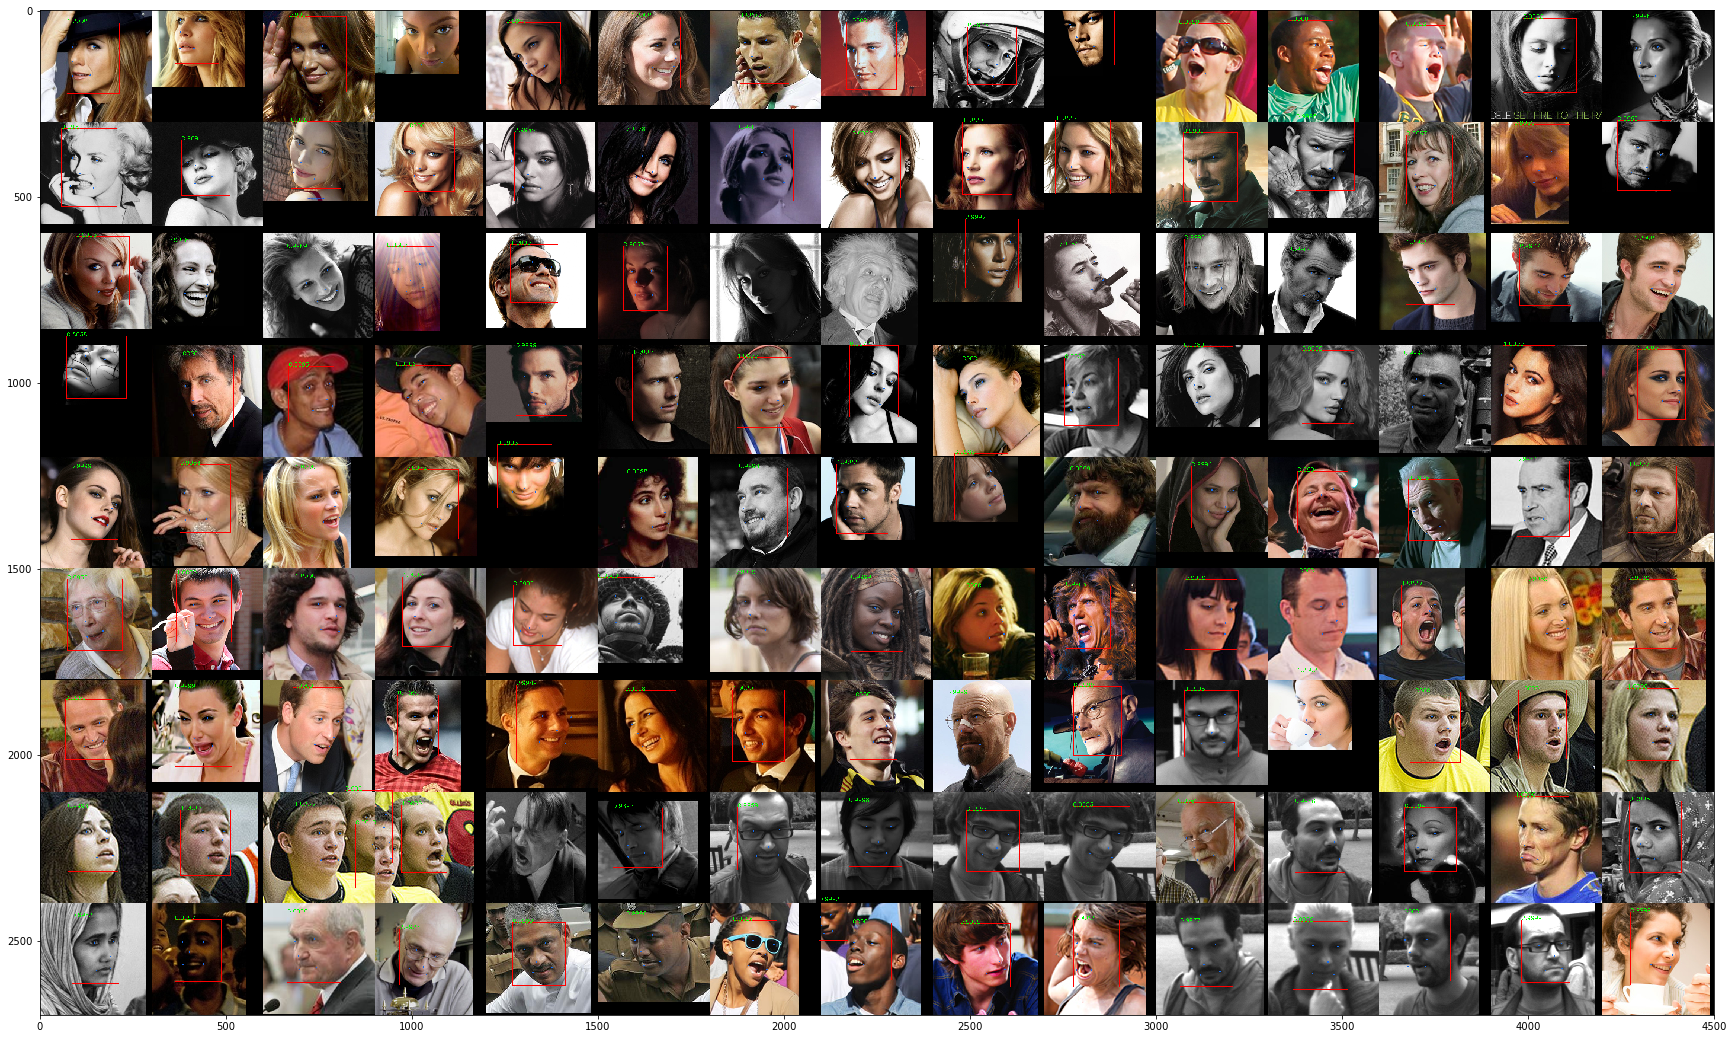

In [10]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
from scipy.io import loadmat
from PIL import Image as PImage
from scipy.misc import imresize
import copy
I = np.array(PImage.open(source_path))
canvas = I.copy()
for i in range(bounding_boxes.shape[0]):
    cv2.rectangle(canvas,(int(bounding_boxes[i][0]),int(bounding_boxes[i][1])),(int(bounding_boxes[i][2]),int(bounding_boxes[i][3])),(255,0,0))
    cv2.putText(canvas,'%.4f' % bounding_boxes[i][-1],(int(bounding_boxes[i][0]),int(bounding_boxes[i][1])),cv2.FONT_ITALIC,0.5,(0,255,0))
    for j in range(int(points.shape[0]/2)):
        cv2.circle(canvas, (int(points[j, i]), int(points[j+5, i])), 2, (24,109,238), -1)
#plt.imshow(canvas/255)
plt.figure(figsize=(30,30))
plt.imshow(canvas)

### restore face network

In [68]:
def lms_to_heatmap(lms, h, w, n_landmarks, sigma=3.):
    xs, ys = np.meshgrid(np.arange(0.,w), np.arange(0., h))
    gaussian = (1. / (sigma * np.sqrt(2. * np.pi)))



    def gaussian_fn(lms):
        y, x, idx = lms
        return np.exp(-0.5 * (np.power(ys - y, 2) + np.power(xs - x, 2)) *
                   np.power(1. / sigma, 2.)) * gaussian * 17.


    img_hm = np.stack(list(map(
            gaussian_fn,
            np.concatenate([lms, np.arange(0,n_landmarks)[..., None]], axis=1)
        )), axis=-1)


    return Image.init_from_channels_at_back(img_hm)

In [103]:
with tf.Graph().as_default() as g:
    model_path = 'ckpt/face1968/model.ckpt-250635'

    images_input = tf.placeholder(tf.float32, shape=(None, None, None, 8), name='input_images')

    layers = []
    net_model = networks.DNFace1968('saved/weight.pkl')
    with tf.variable_scope('net'):
        with slim.arg_scope([slim.batch_norm, slim.layers.dropout], is_training=False):
            lms_heatmap_prediction, states = net_model._build_network(images_input)
            lms_hm_19,lms_hm_39,lms_hm_68 = states
            
with tf.Session(graph=g) as sess:

    variables_to_restore = slim.get_variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)

    saver.restore(sess, model_path)
    
    img = Image.init_from_channels_at_back(I)
    
    predictions = []
    
    for (x1,y1,x2,y2,score),pts5 in zip(bounding_boxes,print_progress(points.T.reshape(-1,2,5).transpose((0,2,1)))):
        bbox_pts = [[y1,x1],[y2,x2]]
        pts5box = PointCloud(bbox_pts)
        head_scale = pts5box.norm()
        scale = head_scale / 180
        centre = pts5box.centre()
        pimg  = img.copy()
        pimg.landmarks['PTS'] = PointCloud(pts5)
        # crop 384
        cimg, trans, c_scale = utils.crop_image(pimg, centre, scale, [384,384])
        
        # heatmap
        
        
        n_landmarks = 5
        hm5 = lms_to_heatmap(cimg.landmarks['PTS'].lms.points,384,384,n_landmarks)
        
        # crop to 256 * 256
        offset = (384 - 256) / 2
        
        image = cimg.crop((offset,offset),(offset+256,offset+256))
        gt_heatmaps = hm5.crop((offset,offset),(offset+256,offset+256))
        
        input_pixels = np.concatenate([image.pixels_with_channels_at_back() / 255., gt_heatmaps.pixels_with_channels_at_back()], axis=-1)
        lms_hm_prediction, *states_prediction = sess.run(
        [lms_heatmap_prediction] + states[0::2], 
        feed_dict={images_input: input_pixels[None, ...]})
        
        pred19hm, pred68hm = states_prediction
        predictions.append([pred19hm,pred68hm,c_scale,trans])

[=================== ] 99% (134/135) - 00:00:01 remaining                       

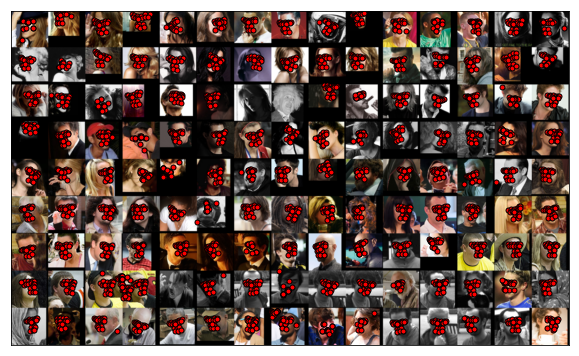

In [104]:
Image.init_from_channels_at_back(I).view()
for lms_hm_prediction19,lms_hm_prediction68,c_scale,trans in predictions:

    # 19 points

    lms_hm_prediction_filter19 = np.stack(list(map(
                lambda x: scipy.ndimage.filters.gaussian_filter(*x),
                zip(lms_hm_prediction19[0].transpose(2,0,1), [3] * 19))))

    hs = np.argmax(np.max(lms_hm_prediction_filter19, 2), 1)
    ws = np.argmax(np.max(lms_hm_prediction_filter19, 1), 1)
    pts_predictions19 = np.stack([hs,ws]).T

    orig_pts19 = trans.apply(PointCloud((pts_predictions19 + np.array([offset,offset])) * c_scale))
    orig_pts19.view()

    # 68 points

    lms_hm_prediction_filter68 = np.stack(list(map(
                lambda x: scipy.ndimage.filters.gaussian_filter(*x),
                zip(lms_hm_prediction68[0].transpose(2,0,1), [3] * 68))))

    hs = np.argmax(np.max(lms_hm_prediction_filter68, 2), 1)
    ws = np.argmax(np.max(lms_hm_prediction_filter68, 1), 1)
    pts_predictions68 = np.stack([hs,ws]).T

    orig_pts68 = trans.apply(PointCloud((pts_predictions19 + np.array([offset,offset])) * c_scale))

### load record & landmark localisation

In [ ]:
data_set = 'ibug_test'
filename = '/vol/atlas/databases/to_yuxiang/testset/%s.tfrecords'%data_set
provider = data_provider.ProtobuffProvider('%s.tfrecords'%data_set,'/vol/atlas/databases/to_yuxiang/testset/')
data = []
for j,serialized_example in enumerate(tf.python_io.tf_record_iterator(filename)):
    features = provider._get_features(serialized_example)
    
    # image
    image, image_height, image_width = provider._image_from_feature(features)
    gt_heatmaps, _, _ = provider._heatmap_from_feature(features)

    detector_pts5 = gt_heatmaps[1]
    
    # infomations
    scale = provider._info_from_feature(features)
    
    # crop to 256 * 256
    target_h = tf.to_int32(256)
    target_w = tf.to_int32(256)
    offset_h = tf.to_int32((image_height - target_h) / 2)
    offset_w = tf.to_int32((image_width - target_w) / 2)

    image = tf.image.crop_to_bounding_box(
        image, offset_h, offset_w, target_h, target_w)
    
    detector_pts5 = tf.image.crop_to_bounding_box(
        detector_pts5, offset_h, offset_w, target_h, target_w)

    image_pixel, detector_pixel = sess.run([image, detector_pts5])
    input_pixels = np.concatenate([image_pixel / 255., detector_pixel], axis=-1)
    lms_hm_prediction, *states_prediction = sess.run(
        [lms_heatmap_prediction] + states, 
        feed_dict={images_input: input_pixels[None, ...]})
    
    data.append([input_pixels, lms_hm_prediction,states_prediction])
    
    if j > 10:
        break

### visualisation

In [129]:
input_pixels, lms_hm_prediction,states_prediction = data[5]
lms_hm_prediction = states_prediction[2]

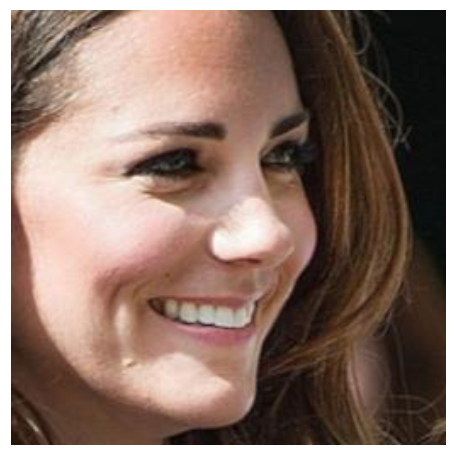

In [130]:
Image.init_from_channels_at_back(input_pixels[:,:,:3]).view()
# Image.init_from_channels_at_back(np.mean(lms_hm_prediction[0],axis=-1)).view(alpha=0.75)

In [131]:
# Image.init_from_channels_at_back(lms_hm_prediction[0]).view()

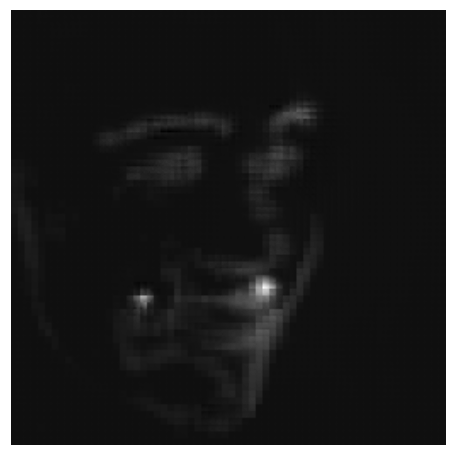

In [132]:
Image.init_from_channels_at_back(np.mean(lms_hm_prediction[0], axis=-1)).view()

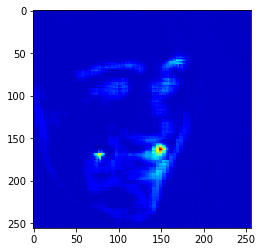

In [137]:
plt.imshow(np.mean(lms_hm_prediction[0], axis=-1), cmap=plt.cm.jet)

In [133]:
hs = np.argmax(np.max(lms_hm_prediction.squeeze().transpose(2,0,1), 2), 1)
ws = np.argmax(np.max(lms_hm_prediction.squeeze().transpose(2,0,1), 1), 1)
pts_predictions = np.stack([hs,ws]).T

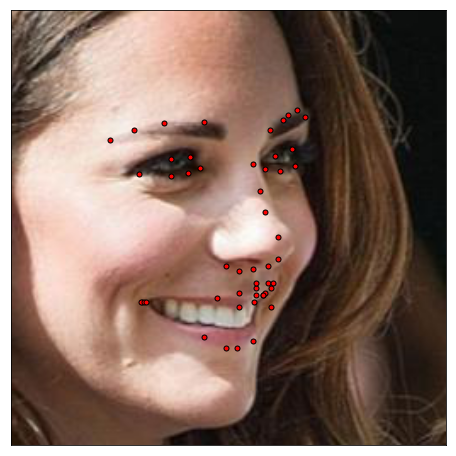

In [134]:
Image.init_from_channels_at_back(input_pixels[:,:,:3]).view()
PointCloud(pts_predictions[17:]).view()

### TF Record Generation

In [ ]:
### JKFace

#### train

store_path = Path('/vol/atlas/databases/to_yuxiang/')
load_path = Path('/vol/atlas/databases/aflw')
record_name = "data.tfrecords"



def get_jpg_string(im):
    # Gets the serialized jpg from a menpo `Image`.
    fp = BytesIO()
    mio.export_image(im, fp, extension='jpg')
    fp.seek(0)
    return fp.read()

def _int_feauture(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feauture(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feauture(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))



def face_iterator(store_path=store_path,image_load_path=load_path):
    annotations = sio.loadmat(str(store_path/'anno.mat'), squeeze_me=True, struct_as_record=False)
    

    for idx, data in enumerate(print_progress(annotations['AFLWface'])):
        
        image_path = image_load_path / data.name
        
        image_name = image_path.name

        img = utils.import_image(image_path)

        img.landmarks['bbox'] = PointCloud(data.pts5box.reshape(-1,2)[:,-1::-1])
        img.landmarks['pts5'] = PointCloud(data.pts5[:,-1::-1])
        img.landmarks['pts19'] = PointCloud(data.pts19[:,-1::-1])
        
        gt_pts = np.zeros((68,2))
        
        n_landmarks = len(data.pts3968)
        
        if n_landmarks > 0:
            gt_pts[:n_landmarks,:] = data.pts3968[:,-1::-1]

        img.landmarks['pts'] = PointCloud(gt_pts)

        pts5box = PointCloud(data.pts5box.reshape(-1,2)[:,-1::-1])
        head_scale = pts5box.norm()
        scale = head_scale / 180
        centre = pts5box.centre()
        
        yield image_name, img, np.where(data.pts19vis)[0], list(range(19)), [], scale, centre, head_scale, n_landmarks

def generate(iterator,
             store_path=store_path,
             record_name='data.tfrecords',
             store_files=False,
             store_records=True):

    store_path = Path(store_path)

    if store_records:
        writer = tf.python_io.TFRecordWriter(str(store_path/record_name))

    for img_name, pimg, visible_pts, marked_index, pts_index, scale, centre, head_scale, n_landmarks in iterator:

        #crop images and store necessary information
        cimg, trans, c_scale = utils.crop_image(pimg, centre, scale, [384,384])
        bbox = cimg.landmarks['bbox'].lms
        pts = cimg.landmarks['pts'].lms
        pts5 = cimg.landmarks['pts5'].lms
        pts19 = cimg.landmarks['pts19'].lms

        img_path = store_path / '{}'.format(img_name)

        if store_records:
            # construct the Example proto boject
            example = tf.train.Example(
                features=tf.train.Features(
                  # Features contains a map of string to Feature proto objects
                  feature={
                    # images
                    'image': _bytes_feauture(get_jpg_string(cimg)),
                    'height': _int_feauture(cimg.shape[0]),
                    'width': _int_feauture(cimg.shape[1]),
                    # landmarks
                    'n_landmarks': _int_feauture(n_landmarks),
                    'gt': _bytes_feauture(pts.points.astype(np.float32).tobytes()),
                    'gt5': _bytes_feauture(pts5.points.astype(np.float32).tobytes()),
                    'gt19': _bytes_feauture(pts19.points.astype(np.float32).tobytes()),
                    
                    'scale': _float_feauture(head_scale / c_scale),
                    # original infomations
                    'original_scale': _float_feauture(scale),
                    'original_centre': _bytes_feauture(centre.astype(np.float32).tobytes()),
                    # inverse transform to original landmarks
                    'restore_translation': _bytes_feauture(trans.h_matrix.astype(np.float32).tobytes()),
                    'restore_scale': _float_feauture(c_scale),
            }))
            # use the proto object to serialize the example to a string
            serialized = example.SerializeToString()
            # write the serialized object to disk
            writer.write(serialized)
    if store_records:
        writer.close()

generate(face_iterator(), store_path, record_name, store_files=False, store_records=True)





#### test

set_name = 'ibug_test'
store_path = Path('/vol/atlas/databases/to_yuxiang/testset/')
load_path = Path('/vol/atlas/databases/to_yuxiang/testset/')
record_name = "%s.tfrecords"%set_name



def get_jpg_string(im):
    # Gets the serialized jpg from a menpo `Image`.
    fp = BytesIO()
    mio.export_image(im, fp, extension='jpg')
    fp.seek(0)
    return fp.read()

def _int_feauture(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feauture(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feauture(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))



def face_iterator(store_path=store_path,image_load_path=load_path):
    annotations = sio.loadmat(str(store_path/('%s.mat'%set_name)), squeeze_me=True, struct_as_record=False)
    

    for idx, data in enumerate(print_progress(annotations['anno'])):
        
        image_path = image_load_path / data.name
        
        image_name = image_path.name

        img = utils.import_image(image_path)

        img.landmarks['bbox'] = PointCloud(data.pts5box.reshape(-1,2)[:,-1::-1])
        img.landmarks['pts5'] = PointCloud(data.pts5[:,-1::-1])
        img.landmarks['pts'] = PointCloud(data.pts[:,-1::-1])
        

        pts5box = PointCloud(data.pts5box.reshape(-1,2)[:,-1::-1])
        head_scale = pts5box.norm()
        scale = head_scale / 180
        centre = pts5box.centre()
        
        yield image_name, img, list(range(68)), list(range(68)), [], scale, centre, head_scale

def generate(iterator,
             store_path=store_path,
             record_name='data.tfrecords',
             store_files=False,
             store_records=True):

    store_path = Path(store_path)

    if store_records:
        writer = tf.python_io.TFRecordWriter(str(store_path/record_name))

    for img_name, pimg, visible_pts, marked_index, pts_index, scale, centre, head_scale in iterator:

        #crop images and store necessary information
        cimg, trans, c_scale = utils.crop_image(pimg, centre, scale, [384,384])
        bbox = cimg.landmarks['bbox'].lms
        pts = cimg.landmarks['pts'].lms
        pts5 = cimg.landmarks['pts5'].lms

        img_path = store_path / '{}'.format(img_name)

        if store_records:
            # construct the Example proto boject
            example = tf.train.Example(
                features=tf.train.Features(
                  # Features contains a map of string to Feature proto objects
                  feature={
                    # images
                    'image': _bytes_feauture(get_jpg_string(cimg)),
                    'height': _int_feauture(cimg.shape[0]),
                    'width': _int_feauture(cimg.shape[1]),
                    # landmarks
                    'n_landmarks': _int_feauture(68),
                    'gt': _bytes_feauture(pts.points.astype(np.float32).tobytes()),
                    'gt5': _bytes_feauture(pts5.points.astype(np.float32).tobytes()),
                    
                    'scale': _float_feauture(head_scale / c_scale),
                    # original infomations
                    'original_scale': _float_feauture(scale),
                    'original_centre': _bytes_feauture(centre.astype(np.float32).tobytes()),
                    # inverse transform to original landmarks
                    'restore_translation': _bytes_feauture(trans.h_matrix.astype(np.float32).tobytes()),
                    'restore_scale': _float_feauture(c_scale),
            }))
            # use the proto object to serialize the example to a string
            serialized = example.SerializeToString()
            # write the serialized object to disk
            writer.write(serialized)
    if store_records:
        writer.close()

generate(face_iterator(), store_path, record_name, store_files=False, store_records=True)

set_name = 'ibug_test'
store_path = Path('/vol/atlas/databases/to_yuxiang/testset/')
load_path = Path('/vol/atlas/databases/to_yuxiang/testset/')
record_name = "%s.tfrecords"%set_name


def get_jpg_string(im):
    # Gets the serialized jpg from a menpo `Image`.
    fp = BytesIO()
    mio.export_image(im, fp, extension='jpg')
    fp.seek(0)
    return fp.read()

def _int_feauture(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feauture(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feauture(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))



def face_iterator(store_path=store_path,image_load_path=load_path):
    annotations = sio.loadmat(str(store_path/'anno.mat'), squeeze_me=True, struct_as_record=False)
    

    for idx, data in enumerate(print_progress(annotations['AFLWface'])):
        
        image_path = image_load_path / data.name
        
        image_name = image_path.name

        img = utils.import_image(image_path)

        img.landmarks['bbox'] = PointCloud(data.pts5box.reshape(-1,2)[:,-1::-1])
        img.landmarks['pts5'] = PointCloud(data.pts5[:,-1::-1])
        img.landmarks['pts19'] = PointCloud(data.pts5[:,-1::-1])
        img.landmarks['pts'] = PointCloud(data.pts[:,-1::-1])
        
        pts5box = PointCloud(data.pts5box.reshape(-1,2)[:,-1::-1])
        head_scale = pts5box.norm()
        scale = head_scale / 180
        centre = pts5box.centre()
        
        yield image_name, img, list(range(68)), list(range(68)), [], scale, centre, head_scale, 68

def generate(iterator,
             store_path=store_path,
             record_name='data.tfrecords',
             store_files=False,
             store_records=True):

    store_path = Path(store_path)

    if store_records:
        writer = tf.python_io.TFRecordWriter(str(store_path/record_name))

    for img_name, pimg, visible_pts, marked_index, pts_index, scale, centre, head_scale, n_landmarks in iterator:

        #crop images and store necessary information
        cimg, trans, c_scale = utils.crop_image(pimg, centre, scale, [384,384])
        bbox = cimg.landmarks['bbox'].lms
        pts = cimg.landmarks['pts'].lms
        pts5 = cimg.landmarks['pts5'].lms
        pts19 = cimg.landmarks['pts19'].lms

        img_path = store_path / '{}'.format(img_name)

        if store_records:
            # construct the Example proto boject
            example = tf.train.Example(
                features=tf.train.Features(
                  # Features contains a map of string to Feature proto objects
                  feature={
                    # images
                    'image': _bytes_feauture(get_jpg_string(cimg)),
                    'height': _int_feauture(cimg.shape[0]),
                    'width': _int_feauture(cimg.shape[1]),
                    # landmarks
                    'n_landmarks': _int_feauture(n_landmarks),
                    'gt': _bytes_feauture(pts.points.astype(np.float32).tobytes()),
                    'gt5': _bytes_feauture(pts5.points.astype(np.float32).tobytes()),
                    'gt19': _bytes_feauture(pts19.points.astype(np.float32).tobytes()),
                    
                    'scale': _float_feauture(head_scale / c_scale),
                    # original infomations
                    'original_scale': _float_feauture(scale),
                    'original_centre': _bytes_feauture(centre.astype(np.float32).tobytes()),
                    # inverse transform to original landmarks
                    'restore_translation': _bytes_feauture(trans.h_matrix.astype(np.float32).tobytes()),
                    'restore_scale': _float_feauture(c_scale),
            }))
            # use the proto object to serialize the example to a string
            serialized = example.SerializeToString()
            # write the serialized object to disk
            writer.write(serialized)
    if store_records:
        writer.close()

generate(face_iterator(), store_path, record_name, store_files=False, store_records=True)